# Original analysis
## Define policy functions 

In [151]:
"""
monitoring stricy based on level of uncertianty (coeficent of variation)
"""
function sigma_only(s, sigma_min)
    if s[2][1,1] > sigma_min
        return 1
    else
        return 0
    end 
end 

"""
monitoring based on high abundace and uncertainty 
"""
function top_corner(s, sigma_min, B_min)
    if (s[2][1,1] > sigma_min) & (exp(s[1][1] + 0.5*s[2][1,1]) > B_min)
        return 1
    else
        return 0
    end 
end 


"""
monitoring based on low abundace or uncertainty 
"""
function low_abundance(s, sigma_min, B_min)
    if (s[2][1,1] > sigma_min) | (exp(s[1][1] + 0.5*s[2][1,1]) < B_min)
        return 1
    else
        return 0
    end 
end 

"""
monitoring based on low abundace and uncertainty 
"""
function bottom_corner(s, sigma_min, B_min)
    if (s[2][1,1] > sigma_min) & (exp(s[1][1] + 0.5*s[2][1,1]) < B_min)
        return 1
    else
        return 0
    end 
end 




bottom_corner

In [ ]:
include("SurplusProduction.jl")
include("../src/BeliefStateTransitions.jl")
params = SurplusProduction.reparam(10,0.2)
T = (x,actions,aux) -> SurplusProduction.Bt_alt_pstar(x,actions,aux,params)
SigmaN = [0.05;;]

# pstar sigma
Fmin = 0.02
Fmax = 0.2
Bmin = 0.1 * 110 
Bcrit = 0.4 * 110 
Hmax = 200
pstar = 0.4
aux = state -> SurplusProduction.pstar_sigma(pstar,state,(Bmin,Bcrit,Fmin,Fmax),Hmax)

# new observation model 
H = [1.0;;]
function SigmaO(actions,aux)
    Sigma_O = zeros(1,1)
    if actions == 1
        Sigma_O[1,1] = 0.1
    else
        Sigma_O[1,1] = 1.5
    end
    return Sigma_O
end 

# define model object to compute grid 
actions = [0,1]
model_40_10=BeliefStateTransitions.init_model(T,aux,H,actions,SigmaO,SigmaN)  


In [153]:
sigma_min = 0.125
B_min = 30.0
B_max = 60.0
sigma_min2 = 0.0
P1 = s -> sigma_only(s, sigma_min)
P2 = s -> top_corner(s, sigma_min, B_min)
P3 = s -> low_abundance(s, sigma_min, B_min)
P4 = s -> bottom_corner(s, sigma_min, B_max)
P5 = s -> bottom_corner(s, sigma_min2, B_min)

#100 (generic function with 1 method)

In [154]:
include("../src/ParticleFilters.jl")
include("../src/BeliefStateTransitions.jl")
using Distributions
using Plots
using LaTeXStrings

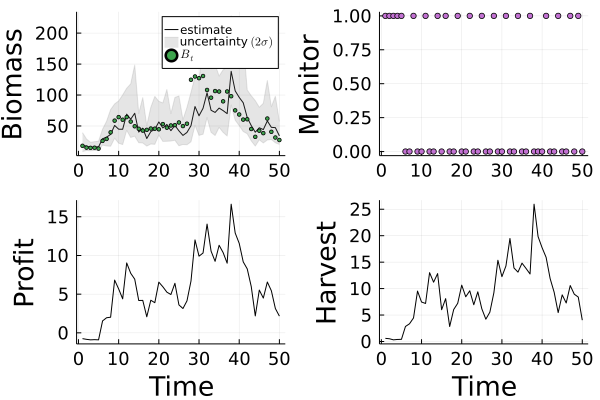

In [157]:
x0 = [log(18)]
s0 = ([log(18)], [0.135;;])
T = 50

filter = BeliefStateTransitions.ParticleFilters.init(500,Distributions.MvNormal(s0[1],s0[2]))
R1 = (x,actions,ct) -> SurplusProduction.Rpstar(x,actions,ct,10,0.0085,1.0)

dat = BeliefStateTransitions.simulation(x0,s0,T,filter,P3,model_40_10,R1)

p1=Plots.plot(broadcast(i -> exp.(dat[2][i][1][1]), 1:T), color = "black", label = "estimate")
Plots.plot!(broadcast(i -> exp.(dat[2][i][1][1] + 2*sqrt(dat[2][i][2][1])), 1:T), 
            fillrange = broadcast(i -> exp.(dat[2][i][1][1] - 2*sqrt(dat[2][i][2][1])), 1:T), 
            alpha =0.2, color = "grey", label = string("uncertainty ", L"(2\sigma)") , ylab = "Biomass")
Plots.scatter!(broadcast(i -> exp(dat[1][i][1]), 1:T), markersize= 2, label = L"B_t")
Plots.plot!(broadcast(i -> exp.(dat[2][i][1][1]- 2*sqrt(dat[2][i][2][1])), 1:T), color = "grey",
            alpha = 0.2, label = "")
p2 = Plots.plot(broadcast(i -> dat[5][i][1][1], 1:T), color = "black", label = "", xlabel = "Time",
ylab = "Profit")

p3=Plots.scatter(broadcast(i -> dat[3][i], 1:T), color = "black", legend = :right, c=4, markersize= 3,ylab = "Monitor", label = "")
p4=Plots.plot(broadcast(i -> dat[4][i], 1:T), color = "black", label = "", xlabel = "Time",
ylab = "Harvest")
plot(p1,p3,p2,p4,layout = (2,2),guidefontsize = 18,tickfontsize = 12)



In [158]:
savefig("figures/example_sim.png")

In [117]:
include("SurplusProduction.jl")
include("../src/BeliefStateTransitions.jl")
using Plots
using Distributions
# biological parameters
Fmsy= 0.2; price=1.0;sigma_a=0.1;sigma_p=1.5;NMVmax = 1.0;Sigma_N=0.05
MSY=10;pstar=0.4;c1 = 1.0/Fmsy;c2=0.0085
c3=1.0;b=2*Fmsy/MSY;discount=0.05;SigmaN=0.05

# solve optimal policy 
model=SurplusProduction.init_model(MSY,Fmsy,pstar,SigmaN,sigma_a,sigma_p,c1,c2,c3,b,
NMVmax*MSY,discount;price=price,N=50,actions=[1,2],CVmax=1.05)
policy =  s -> model.Policy([s[1][1],s[2][1,1]])

# initial conditions for simulation  
B0 = MSY/Fmsy
sigma0 = 0.1

0.1

In [127]:
model.Value([log(10),0.1])

165.67761826909418

In [118]:
# lenth of simualtion 
T = 50

# numer fo particle sin beleif state aproximation 
number_of_particles = 1000

filter = BeliefStateTransitions.ParticleFilters.init(number_of_particles,Distributions.MvNormal([log(B0)],[sigma0;;]))
x0 = [rand(Distributions.Normal(log(B0), sqrt(sigma0)))]
s0 = ([log(B0)],[sigma0;;])

dat = BeliefStateTransitions.simulation(x0,s0,T,filter,policy,model.mod,model.Returns)
print(" ")

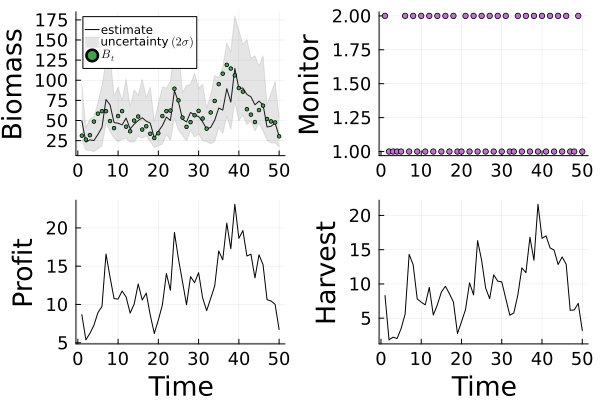

In [119]:
using LaTeXStrings
p1=Plots.plot(broadcast(i -> exp.(dat[2][i][1][1]), 1:T), color = "black", label = "estimate")
Plots.plot!(broadcast(i -> exp.(dat[2][i][1][1] + 2*sqrt(dat[2][i][2][1])), 1:T), 
            fillrange = broadcast(i -> exp.(dat[2][i][1][1] - 2*sqrt(dat[2][i][2][1])), 1:T), 
            alpha =0.2, color = "grey", label = string("uncertainty ", L"(2\sigma)") , ylab = "Biomass")
Plots.scatter!(broadcast(i -> exp(dat[1][i][1]), 1:T), markersize= 2, label = L"B_t")
Plots.plot!(broadcast(i -> exp.(dat[2][i][1][1]- 2*sqrt(dat[2][i][2][1])), 1:T), color = "grey",
            alpha = 0.2, label = "")
p2 = Plots.plot(broadcast(i -> dat[5][i][1][1], 1:T), color = "black", label = "", xlabel = "Time",
ylab = "Profit")

p3=Plots.scatter(broadcast(i -> dat[3][i], 1:T), color = "black", legend = :right, c=4, markersize= 3,ylab = "Monitor", label = "")
p4=Plots.plot(broadcast(i -> dat[4][i], 1:T), color = "black", label = "", xlabel = "Time",
ylab = "Harvest")
plot(p1,p3,p2,p4,layout = (2,2),guidefontsize = 18,tickfontsize = 12)

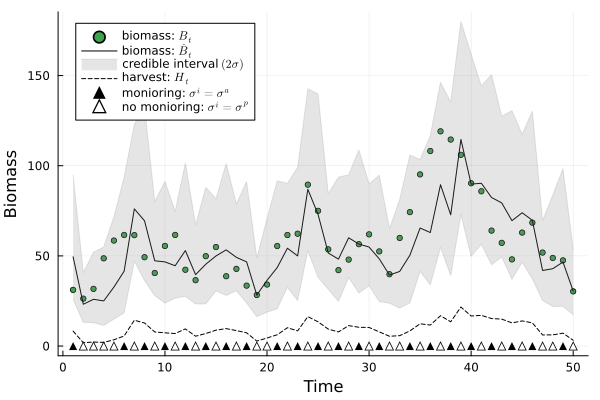

In [129]:

Plots.scatter(broadcast(i -> exp(dat[1][i][1]), 1:T), markersize= 3, label = string("biomass: ",L"B_t"),c=3)
Plots.plot!(broadcast(i -> exp.(dat[2][i][1][1]), 1:T), color = "black", label = string("biomass: ",L"\hat{B}_t"))
Plots.plot!(broadcast(i -> exp.(dat[2][i][1][1] + 2*sqrt(dat[2][i][2][1])), 1:T), 
            fillrange = broadcast(i -> exp.(dat[2][i][1][1] - 2*sqrt(dat[2][i][2][1])), 1:T), 
            alpha =0.2, color = "grey", label = string("credible interval ", L"(2\sigma)") , ylab = "Biomass")
Plots.plot!(broadcast(i -> exp.(dat[2][i][1][1]- 2*sqrt(dat[2][i][2][1])), 1:T), color = "grey",
            alpha = 0.2, label = "")
inds = collect(1:T)[broadcast(i -> dat[3][i], 1:T) .== 2]
y = zeros(length(inds))
inds_0 = collect(1:T)[broadcast(i -> dat[3][i], 1:T) .== 1]
y_0 = zeros(length(inds))
Plots.plot!(broadcast(i -> dat[4][i], 1:T), color = "black", label = string("harvest: ", L"H_t"), 
xlabel = "Time",linestyle = :dash)
Plots.scatter!(inds,y,markershape = :utriangle, color = "black",markersize = 4,
                label = string("monioring: ", L"\sigma^{i} = \sigma^a"))
Plots.scatter!(inds_0,y_0,markershape = :utriangle, color = "white",markersize = 4,
                label = string("no monioring: ", L"\sigma^{i} = \sigma^p"))


# New section 

In [90]:


T = 95
NMC = 10
delta = 1/(1+0.05)
B0 = [11,50,110]
sigma0 = [0.0606, 0.1315, 0.223]


filter = BeliefStateTransitions.ParticleFilters.init(500,Distributions.MvNormal(s0[1],s0[2]))
    
R1 = (x,actions,ct) -> SurplusProduction.Rpstar(x,actions,ct,10,0.0085,1.0)

function NPV(B0, sigma0, P,delta, T, model, R;Nfilter = 500)
    
    filter = BeliefStateTransitions.ParticleFilters.init(Nfilter,Distributions.MvNormal([log(B0)],[sigma0;;]))
    x0 = [rand(Distributions.Normal(log(B0), sqrt(sigma0)))]
    s0 = ([log(B0)],[sigma0;;])
    
    dat = BeliefStateTransitions.simulation(x0,s0,T,filter,P,model,R)
    
    return sum(broadcast(t -> dat[5][t] * delta^t, 1:T))
    
end 
    
function ENPV(B0, sigma0, P,delta, T, NMC, model,  R;Nfilter = 500)
    
    acc = zeros(NMC)
    for i in 1:NMC
        if mod(i,100) == 0
            print(i, " ")
        end 
        acc[i] = NPV(B0, sigma0, P,delta, T, model, R;Nfilter = Nfilter)
    end 
    
    return sum(acc)/NMC
        
end 
    


ENPV (generic function with 1 method)

In [142]:
NMC = 1000
acc = zeros(9*4,4)
init_conditions = collect(Iterators.product(B0,sigma0))
Pls = (P1,P2,P3,P4)
models = broadcast(i->deepcopy(model_40_10), 1:Threads.nthreads())

R = (x,actions,ct) -> SurplusProduction.Rpstar(x,actions,ct,10,0.0085,1.5)
k = 0
for i in 1:4
    Threads.@threads for j in 1:length(init_conditions)
        
        x0 = init_conditions[j]

        ind = (i-1)*length(init_conditions)+j
        acc[ind,1] =  i
        acc[ind,2] = init_conditions[j][1]
        acc[ind,3] = init_conditions[j][2]
        acc[ind,4] = ENPV(x0[1],x0[2],Pls[i],delta,T,NMC, models[Threads.threadid()], R;Nfilter = 1000)
    end
end 

100 100 100 100 100 100 100 100 100 200 200 200 200 200 200 200 200 200 300 300 300 300 300 300 300 300 300 400 400 400 400 400 400 400 400 400 500 500 500 500 500 500 500 500 500 600 600 600 600 600 600 600 600 600 700 700 700 700 700 700 700 700 700 800 800 800 800 800 800 800 800 800 900 900 900 900 900 900 900 900 900 1000 1000 1000 1000 1000 1000 1000 1000 1000 100 100 100 100 100 100 100 100 100 200 200 200 200 200 200 200 200 200 300 300 300 300 300 300 300 300 300 400 400 400 400 400 400 400 400 400 500 500 500 500 500 500 500 500 500 600 600 600 600 600 600 600 600 600 700 700 700 700 700 700 700 700 700 800 800 800 800 800 800 800 800 800 900 900 900 900 900 900 900 900 900 1000 1000 1000 1000 1000 1000 1000 1000 1000 100 100 100 100 100 100 100 100 100 200 200 200 200 200 200 200 200 200 300 300 300 300 300 300 300 300 300 400 400 400 400 400 400 400 400 400 500 500 500 500 500 500 500 500 500 600 600 600 600 600 600 600 600 600 700 700 700 700 700 700 700 700 700 800 800 80

In [144]:
using DelimitedFiles
writedlm( "data/alternative_policiesc3=1.5.csv",  acc, ',')

In [112]:
B = 1:1.0:100
sigma = 0.01:0.005:0.4
acc = zeros(4*length(B)*length(sigma),4)
P = (P1,P2,P3,P4)
k = 0
for i in 1:4
    for s in sigma
        for b in B
            k +=1
            acc[k,1] = b
            acc[k,2] = s
            acc[k,3] = i
            acc[k,4] = P[i](([log(b)],[s;;]))
        end
    end
end


using DelimitedFiles
writedlm( "data/alternative_policies_map.csv",  acc, ',')

In [119]:
# Policy 5
NMC = 1000
acc = zeros(9,4)
init_conditions = collect(Iterators.product(B0,sigma0))

models = broadcast(i->deepcopy(model_40_10), 1:Threads.nthreads())

R = (x,actions,ct) -> SurplusProduction.Rpstar(x,actions,ct,10,0.0085,0.5)


Threads.@threads for j in 1:length(init_conditions)   
    x0 = init_conditions[j]
    ind = j
    acc[ind,1] = 5
    acc[ind,2] = init_conditions[j][1]
    acc[ind,3] = init_conditions[j][2]
    acc[ind,4] = ENPV(x0[1],x0[2],P5,delta,T,NMC, models[Threads.threadid()], R; Nfilter = 1000)
end


using DelimitedFiles
writedlm( "data/alternative_policies_P5_c3=0.5.csv",  acc, ',')

100 100 100 100 100 100 100 100 100 200 200 200 200 200 200 200 200 200 300 300 300 300 300 300 300 300 300 400 400 400 400 400 400 400 400 400 500 500 500 500 500 500 500 500 500 600 600 600 600 600 600 600 600 600 700 700 700 700 700 700 700 700 700 800 800 800 800 800 800 800 800 800 900 900 900 900 900 900 900 900 900 1000 1000 1000 1000 1000 1000 1000 1000 1000 

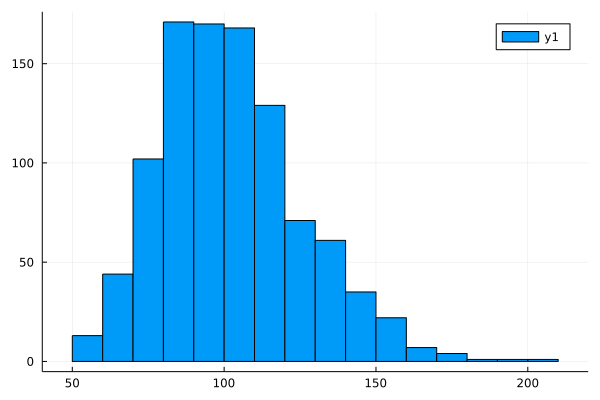

In [130]:
Plots.histogram(100 .*exp.(reshape(rand(Distributions.MvNormal(zeros(1),[0.05;;]),1000),1000)))

# New analysis 

In [1]:
include("SurplusProduction.jl")
include("../src/ParticleFilters.jl")
include("../src/BeliefStateTransitions.jl")
Fmsy= 0.2; price=1.0;sigma_a=0.1;sigma_p=1.5;NMVmax = 1.0;Sigma_N=0.05
MSY=10;pstar=0.4;c1 = 1.0/Fmsy;c2=0.0085
c3=2.0;b=2*Fmsy/MSY;discount=0.05;SigmaN=0.05
model=SurplusProduction.init_model(MSY,Fmsy,pstar,SigmaN,sigma_a,sigma_p,c1,c2,c3,b,
                                        NMVmax*MSY,discount;price=price,N=25,actions=[1,2],CVmax=1.05)
print(" ")

In [2]:

"""
monitoring stricy based on level of uncertianty (coeficent of variation)
"""
function steps(s, Bhat_breaks, sigma_levels)
    
    if s[1][1] < Bhat_breaks[1]
        if s[2][1,1] > sigma_levels[1]
            return 2
        else
            return 1
        end 
    elseif s[1][1] <Bhat_breaks[2]
        if s[2][1,1] > sigma_levels[2]
            return 2
        else
            return 1
        end 
    else
        if s[2][1,1] > sigma_levels[3]
            return 2
        else
            return 1
        end 
    end 
    
end 

policy1=  s -> model.Policy([s[1][1],s[2][1,1]])
policy2 = s -> steps(s, log.([25.0,50.0]), [log(0.388^2+1),log(0.388^2+1),log(0.388^2+1)])
policy3 = s -> steps(s, log.([25.0,55.0]), [log(0.2^2+1),log(0.388^2+1),log(0.388^2+1)])
policy4 = s -> steps(s, log.([25.0,55.0]), [log(0.2^2+1),log(0.388^2+1),log(0.55^2+1)])

#7 (generic function with 1 method)

In [3]:
include("../src/BeliefStateTransitions.jl")
include("../src/ParticleFilters.jl")
using Distributions
T = 95
delta = 1/(1+0.05)
B0 = [11,50,110]
sigma0 = [0.0606, 0.1315, 0.223]
s0 = [[0.0],[1.0;;]]

filter = BeliefStateTransitions.ParticleFilters.init(500,Distributions.MvNormal(s0[1],s0[2]))
    
function NPV(B0, sigma0, P,delta, T, model, R;Nfilter = 500)
    
    filter = BeliefStateTransitions.ParticleFilters.init(Nfilter,Distributions.MvNormal([log(B0)],[sigma0;;]))#sigma0
    x0 = [rand(Distributions.Normal(log(B0), sqrt(sigma0)))]
    s0 = ([log(B0)],[sigma0;;])
    dat = BeliefStateTransitions.simulation(x0,s0,T,filter,P,model,R)
    if dat =="failed"
        return dat
    end 
        
    return sum(broadcast(t -> dat[5][t] * delta^t, 1:T))
    
end 
    
function ENPV(B0, sigma0, P,delta, T, NMC, model,  R;Nfilter = 500)
    
    acc = zeros(NMC)
    count = 0

    Threads.@threads for i in 1:NMC
        if mod(i,50) == 0
            print(i, " ")
        end 
        npv = NPV(B0, sigma0, P,delta, T, model, R;Nfilter = Nfilter)
        if npv != "failed"
            count += 1
            acc[i] =npv 
        else
            print("failed")   
        end
    end 
              
    return acc
        
end 

ENPV (generic function with 1 method)

In [ ]:

dat =  ENPV(log(100), 0.15, policy4,0.95, 100, 200, model.mod,model.Returns;Nfilter = 1000)

In [ ]:
NMC = 1000;T=100
Policies = [policy1,policy2,policy3,policy4]
acc = zeros(9*4,NMC)
n=0
for init in Iterators.product(B0,sigma0)
    for p in Policies
        n+=1
        acc[n,:] = ENPV(log(100), 0.15, policy4,0.95, T, NMC, model.mod,model.Returns;Nfilter = 1000)
    end 
end 

using CSV
using Tables
CSV.write("data/alt_policies_performance.csv",Tables.table(acc);sep=',')

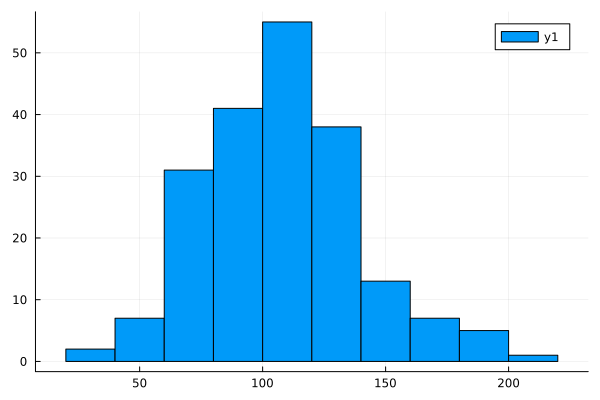

In [94]:
using Plots
Plots.histogram(dat)

In [48]:
mean(x) = sum(x)/length(x)

mean (generic function with 1 method)

In [83]:
mean(dat)

112.66785322058158

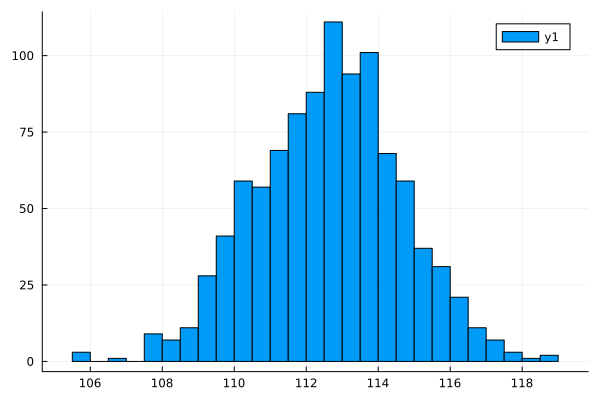

In [69]:
using StatsBase
d = broadcast(i -> mean(dat[StatsBase.sample(1:length(dat),length(dat))]),1:1000)
Plots.histogram(d)

In [74]:
sqrt(sum((d .- mean(d)).^2)/length(d))*sqrt(200)

28.42049917221894

In [95]:
sqrt(sum((dat .- mean(dat)).^2)/length(dat))/sqrt(10000)

0.308433285971145

In [ ]:
NMC = 2000
acc = zeros(9*4,3+NMC)
B0 = [15,50,100]
sigma0 = [log(0.25^2+1), log(0.5^2+1), log(0.75^2+1)]
init_conditions = collect(Iterators.product(B0,sigma0))
Pls = (policy1,policy2,policy3,policy4)#policy1,policy2,
models = broadcast(i->deepcopy(model.mod), 1:Threads.nthreads())

R = (x,actions,ct) -> SurplusProduction.Rpstar(x,actions,ct,10,0.0085,1.5)
k = 0
for i in 1:4
    Threads.@threads for j in 1:length(init_conditions)
        print(i, " ", j, "      ")
        x0 = init_conditions[j]

        ind = (i-1)*length(init_conditions)+j
        acc[ind,1] = i
        acc[ind,2] = init_conditions[j][1]
        acc[ind,3] = init_conditions[j][2]
        acc[ind,4:end] = ENPV(x0[1],x0[2],Pls[i],delta,T,NMC, models[Threads.threadid()], model.Returns;Nfilter = 5000)
    end
end 

using CSV
using Tables
CSV.write("data/alt_policies_performance.csv",Tables.table(acc);sep=',')
CSV.write("data/alt_policies_performance_var.csv",Tables.table(acc_v);sep=',')

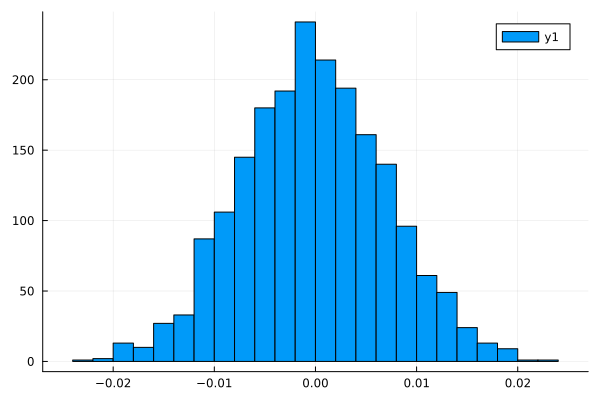

In [38]:
using Distributions
d = Distributions.Normal(0,1)
N = 1000
function samp(N)

    d = Distributions.Normal(0,sqrt(0.5))
    samp = rand(d,N)
    mu = sum(samp)/N
    sigma = sum((samp .- mu).^2)/N
    return mu,sigma
end 
using Plots
Plots.histogram(broadcast(i->samp(10000)[1],1:2000))

In [31]:
CV_vals = collect(0.01:0.005:1.0)
Bhat_vals = 1:1.0:100
monitoring = zeros(length(Bhat_vals),length(CV_vals))
    
acc = zeros(length(CV_vals)*length(Bhat_vals),6)  
k = 0
for i in 1:length(Bhat_vals)
    for j in 1:length(CV_vals)
        Var = log(CV_vals[j]^2+1)
        mu = log(Bhat_vals[i]) - 0.5*Var 
        k+=1
        acc[k,:] = [Bhat_vals[i],CV_vals[j],policy1([mu, Var]).-1,policy2([mu,Var]).-1,
                            policy3([mu,Var]).-1,policy4([mu,Var]).-1]
    end 
end 

using CSV
using Tables
CSV.write("data/alt_policies.csv",Tables.table(acc);sep=',')

"data/alt_policies.csv"

In [49]:
policy3([0.0,1.0])

1

In [55]:
steps([30,0.15], [25,50], [0.07,0.14,0.21])

2

# Simulate assessment frequency

In [133]:
omega = 0.3
gap = 1/omega - 1
acc = 0
count = 0
T = 10000
freq = []
for i in 1:T
    if (gap - acc ) >= 1.0
        acc += 1
    elseif (gap - acc) < 0.0
        count += 1
        push!(freq,acc)
        acc = 0
    elseif (gap - acc) < rand()
        push!(freq,acc)
        count += 1
        acc = 0
    else
        acc+=1
    end
    #print(acc, " ")
end 

count/T
        

0.3002

In [132]:
omega = 0.25
gap = 1/omega  -1

3.0

In [93]:
using FreqTables

FreqTables.proptable(freq)

2-element Named Vector{Float64}
Dim1  │ 
──────┼────────
0     │  1.0e-5
1     │ 0.99999

In [78]:
count

32242

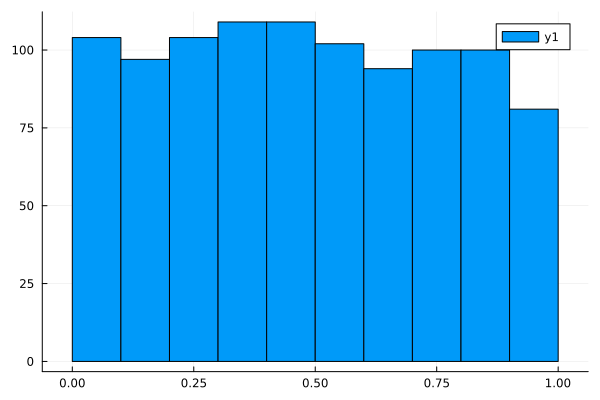

In [41]:
using Plots
Plots.histogram(rand(1000))